# Darwin Mini: ZMP trajectory

Learning from Stephane Caron's introductory article: 
https://scaron.info/teaching/prototyping-a-walking-pattern-generator.html

I would like to create a simple program to determine the optimal COM trajectory such that the ZMP contraints are enforced.  If possible, I don't want to depend on `pymanoid`, because it requires OpenRAVE, which is a pain to install (2h to install on an Ubuntu 18.04 VM!)

I found the following optimizer, which seems to be fit my needs:
https://osqp.org/docs/examples/mpc.html

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from pypot.creatures import DarwinMini

darwin = DarwinMini(simulator='dummy')
# darwin = DarwinMini(simulator='vrep')

In [9]:
from darwin_mini.walk import WalkStraight, WalkingState
from darwin_mini.point import Point
from darwin_mini.mpc import LinearPredictiveControl

import numpy as np


FOOT_LENGTH = 0.088
FOOT_WIDTH = 0.048


class ZMPWalking(WalkStraight):

    def __init__(self, robot, distance, step_duration, frequency=50):
        WalkStraight.__init__(self, robot, distance, step_duration, frequency)
        
        self.mpc_timestep = 1 * self.dt
        self.preview_time = self.mpc_timestep  # to force MPC update at start
        self.com = Point(np.array([0., 0., 0.098]))
        self.com_jerk = [0., 0., 0.]
        # for plotting later
        self.com_points = []
        self.zmp_points = []
        self.footsteps = []

    def get_support_bounds(self):
        l, w = .8 * FOOT_LENGTH, .7 * FOOT_WIDTH
        L = (1. if self.current_step == 0 else 0.5) * self.current_step_length
        stable_foot_pos = self.pos[self.stable_side + '_foot']
        cur_min = (stable_foot_pos[0] - l/2, stable_foot_pos[1] - w/2)
        cur_max = (stable_foot_pos[0] + l/2, stable_foot_pos[1] + w/2)
        next_min = (stable_foot_pos[0] + L - l/2, -stable_foot_pos[1] - w/2)
        next_max = (stable_foot_pos[0] + L + l/2, -stable_foot_pos[1] + w/2)
        return cur_min, cur_max, next_min, next_max
    
    def get_zmp(self, com):
        h = com.p[2]  # z
        g = 9.80665  # m/s2 (ISO 80000-3)
        zmp_from_state = np.array([1., 0., -h / g])
        return [com.p[0] - (h / g) * com.pdd[0],
                com.p[1] - (h / g) * com.pdd[1]]

    def update_mpc(self, dsp_duration, ssp_duration):
        print("update_mpc(): dsp_duration={}, ssp_duration={}".format(dsp_duration, ssp_duration))
        nb_preview_steps = 48  # 16
        T = self.mpc_timestep
        nb_init_dsp_steps = int(round(dsp_duration / T))
        nb_init_ssp_steps = int(round(ssp_duration / T))
        nb_dsp_steps = int(round(self.dsp_duration / T))
        A = np.array([[1., T, T ** 2 / 2.], [0., 1., T], [0., 0., 1.]])
        B = np.array([T ** 3 / 6., T ** 2 / 2., T]).reshape((3, 1))
        h = self.com.p[2]  # z
        g = 9.80665  # m/s2 (ISO 80000-3)
        zmp_from_state = np.array([1., 0., -h / g])
        C = np.array([zmp_from_state, -zmp_from_state])
        D = None
        e = [[], []]
        cur_min, cur_max, next_min, next_max = self.get_support_bounds()
        # print("  update_mpc(): cur_min={}, cur_max={}, next_min={}, next_max={}".format(
        #     cur_min, cur_max, next_min, next_max))
        for k in [0, 1]:
            e[k] = [
                np.array([1000., 1000.]) if i < nb_init_dsp_steps else
                np.array([cur_max[k], -cur_min[k]]) if i - nb_init_dsp_steps <= nb_init_ssp_steps else
                np.array([1000., 1000.]) if i - nb_init_dsp_steps - nb_init_ssp_steps < nb_dsp_steps else
                np.array([next_max[k], -next_min[k]])
                for i in range(nb_preview_steps)]
        # print("  update_mpc(): e = {}".format(e))
        if self.current_step >= len(self.footsteps):
            self.footsteps.append(self.swing_target[:2])
        print("update_mpc(): com=({:.3f},{:.3f}), target=({:.3f}, {:.3f})".format(
            self.com.p[0], self.com.p[1], self.swing_target[0], self.swing_target[1]))
        self.x_mpc = LinearPredictiveControl(
            A, B, C, D, e[0],
            x_init=np.array([self.com.p[0], self.com.pd[0], self.com.pdd[0]]),
            x_goal=np.array([self.swing_target[0], 0., 0.]),
            nb_steps=nb_preview_steps,
            wxt=1., wu=0.01)
        self.y_mpc = LinearPredictiveControl(
            A, B, C, D, e[1],
            x_init=np.array([self.com.p[1], self.com.pd[1], self.com.pdd[1]]),
            x_goal=np.array([self.swing_target[1], 0., 0.]),
            nb_steps=nb_preview_steps,
            wxt=1., wu=0.01)
        self.x_mpc.solve()
        self.y_mpc.solve()
        self.preview_time = 0.

    def run_com_mpc(self, t):
        # p = np.array(self.pos['pelvis'])
        # p[0] = self.com.p[0]  # keep x
        # p[1] = self.com.p[1]  # keep y
        # self.com.set_pos(p)
        if self.preview_time >= self.mpc_timestep:
            if self.state == WalkingState.DOUBLE_SUPPORT:
                self.update_mpc(self.dsp_duration - t, self.ssp_duration)
            else:  # self.state == WalkingState.SINGLE_SUPPORT:
                self.update_mpc(0., self.step_duration - t)
        # com_jerk = [self.x_mpc.U[0][0], self.y_mpc.U[0][0], 0.]
        pdddx, pdddy = self.x_mpc.U[0][0], self.y_mpc.U[0][0]
        print("run_com_mpc(): u = {}, {}".format(pdddx, pdddy))
        if pdddx is not None:
            self.com_jerk[0] = pdddx
        if pdddy is not None:
            self.com_jerk[1] = pdddy
        print("run_com_mpc(): com_jerk = {:.3f}, {:.3f}".format(self.com_jerk[0], self.com_jerk[1]))
        self.com.integrate_constant_jerk(np.array(self.com_jerk), self.dt)
        print("run_com_mpc(): com = {:.3f}, {:.3f}, {:.3f}".format(self.com.p[0], self.com.p[1], self.com.p[2]))
        self.com_points.append(self.com.p[:2])
        self.zmp_points.append(self.get_zmp(self.com))
        self.preview_time += self.dt

    def update_position(self, t):
        super().update_position(t)
        self.run_com_mpc(t)

In [10]:
w = ZMPWalking(darwin, 1.0, 1.0)

w.start()


*** Start step 1 ***
 >> start double support phase <<
update_mpc(): dsp_duration=0.24997591972351074, ssp_duration=0.75
update_mpc(): com=(0.000,0.000), target=(0.050, -0.032)
run_com_mpc(): u = 0.019095194893607913, 13.97020630104829
run_com_mpc(): com_jerk = 0.019, 13.970
run_com_mpc(): com = 0.000, 0.000, 0.098
update_mpc(): dsp_duration=0.22938179969787598, ssp_duration=0.75
update_mpc(): com=(0.000,0.000), target=(0.050, -0.032)
run_com_mpc(): u = 0.01876292825517236, 10.167998228005763
run_com_mpc(): com_jerk = 0.019, 10.168
run_com_mpc(): com = 0.000, 0.000, 0.098
update_mpc(): dsp_duration=0.209089994430542, ssp_duration=0.75
update_mpc(): com=(0.000,0.000), target=(0.050, -0.032)
run_com_mpc(): u = 0.01842922931490698, 6.7000736289745415
run_com_mpc(): com_jerk = 0.018, 6.700
run_com_mpc(): com = 0.000, 0.000, 0.098
update_mpc(): dsp_duration=0.1861109733581543, ssp_duration=0.75
update_mpc(): com=(0.000,0.000), target=(0.050, -0.032)
run_com_mpc(): u = 0.018094190181471535,

update_mpc(): dsp_duration=0.0, ssp_duration=0.16441988945007324
update_mpc(): com=(0.004,0.025), target=(0.050, -0.032)
run_com_mpc(): u = 0.06954424636564667, -0.7719493070954886
run_com_mpc(): com_jerk = 0.070, -0.772
run_com_mpc(): com = 0.004, 0.024, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.14293575286865234
update_mpc(): com=(0.004,0.024), target=(0.050, -0.032)
run_com_mpc(): u = 0.04576858179737239, -0.44196168311743084
run_com_mpc(): com_jerk = 0.046, -0.442
run_com_mpc(): com = 0.004, 0.023, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.1227569580078125
update_mpc(): com=(0.004,0.023), target=(0.050, -0.032)
run_com_mpc(): u = 0.022695070484712962, -0.1444719611537033
run_com_mpc(): com_jerk = 0.023, -0.144
run_com_mpc(): com = 0.005, 0.022, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.09967589378356934
update_mpc(): com=(0.005,0.022), target=(0.050, -0.032)
run_com_mpc(): u = 0.0035726203338592713, 0.15882060711433751
run_com_mpc(): com_jerk = 0.00

update_mpc(): dsp_duration=0.0, ssp_duration=0.31673502922058105
update_mpc(): com=(0.033,-0.032), target=(0.100, 0.032)
run_com_mpc(): u = -0.049264751741906976, -0.07518316326243149
run_com_mpc(): com_jerk = -0.049, -0.075
run_com_mpc(): com = 0.034, -0.031, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.2960169315338135
update_mpc(): com=(0.034,-0.031), target=(0.100, 0.032)
run_com_mpc(): u = -0.049353124138978126, -0.07376793409377681
run_com_mpc(): com_jerk = -0.049, -0.074
run_com_mpc(): com = 0.035, -0.031, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.27465295791625977
update_mpc(): com=(0.035,-0.031), target=(0.100, 0.032)
run_com_mpc(): u = -0.049425695026581784, -0.1296597476237663
run_com_mpc(): com_jerk = -0.049, -0.130
run_com_mpc(): com = 0.036, -0.030, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.25400567054748535
update_mpc(): com=(0.036,-0.030), target=(0.100, 0.032)
run_com_mpc(): u = -0.04948255545829958, -0.14142526298064784
run_com_mpc(): com

run_com_mpc(): u = 0.032316777939429386, -0.9077290327447245
run_com_mpc(): com_jerk = 0.032, -0.908
run_com_mpc(): com = 0.078, 0.036, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.47668886184692383
update_mpc(): com=(0.078,0.036), target=(0.150, -0.032)
run_com_mpc(): u = 0.029244173496528438, -0.9291000380607093
run_com_mpc(): com_jerk = 0.029, -0.929
run_com_mpc(): com = 0.079, 0.037, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.4561939239501953
update_mpc(): com=(0.079,0.037), target=(0.150, -0.032)
run_com_mpc(): u = 0.026280639251526114, -0.9036234977191616
run_com_mpc(): com_jerk = 0.026, -0.904
run_com_mpc(): com = 0.080, 0.038, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.43314480781555176
update_mpc(): com=(0.080,0.038), target=(0.150, -0.032)
run_com_mpc(): u = 0.023411442538641986, -0.87224992652162
run_com_mpc(): com_jerk = 0.023, -0.872
run_com_mpc(): com = 0.082, 0.039, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.41120481491088867
update_

update_mpc(): dsp_duration=0.0, ssp_duration=0.6496908664703369
update_mpc(): com=(0.119,-0.022), target=(0.200, 0.032)
run_com_mpc(): u = 0.042743524888777994, -0.5480779486891361
run_com_mpc(): com_jerk = 0.043, -0.548
run_com_mpc(): com = 0.120, -0.024, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.6276140213012695
update_mpc(): com=(0.120,-0.024), target=(0.200, 0.032)
run_com_mpc(): u = 0.039657424662939436, -0.5254401547315115
run_com_mpc(): com_jerk = 0.040, -0.525
run_com_mpc(): com = 0.121, -0.025, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.6069378852844238
update_mpc(): com=(0.121,-0.025), target=(0.200, 0.032)
run_com_mpc(): u = 0.036620808245515474, -0.5094350873560614
run_com_mpc(): com_jerk = 0.037, -0.509
run_com_mpc(): com = 0.122, -0.027, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.5865857601165771
update_mpc(): com=(0.122,-0.027), target=(0.200, 0.032)
run_com_mpc(): u = 0.03347784214479859, -0.48663885280132324
run_com_mpc(): com_jerk = 0.03

update_mpc(): dsp_duration=0.07599687576293945, ssp_duration=0.75
update_mpc(): com=(0.160,0.004), target=(0.250, -0.032)
run_com_mpc(): u = -0.1293571721960341, -2.1210433489126195
run_com_mpc(): com_jerk = -0.129, -2.121
run_com_mpc(): com = 0.161, 0.006, 0.098
update_mpc(): dsp_duration=0.053128957748413086, ssp_duration=0.75
update_mpc(): com=(0.161,0.006), target=(0.250, -0.032)
run_com_mpc(): u = -0.12224906003167908, -2.1180773323896487
run_com_mpc(): com_jerk = -0.122, -2.118
run_com_mpc(): com = 0.162, 0.009, 0.098
update_mpc(): dsp_duration=0.03308677673339844, ssp_duration=0.75
update_mpc(): com=(0.162,0.009), target=(0.250, -0.032)
run_com_mpc(): u = -0.11544185351139497, -2.094400560761905
run_com_mpc(): com_jerk = -0.115, -2.094
run_com_mpc(): com = 0.163, 0.011, 0.098
update_mpc(): dsp_duration=0.01291799545288086, ssp_duration=0.75
update_mpc(): com=(0.163,0.011), target=(0.250, -0.032)
run_com_mpc(): u = -0.10905209799117553, -2.0154319681838158
run_com_mpc(): com_jerk

run_com_mpc(): u = -0.010796403958761242, 1.6799312407044529
run_com_mpc(): com_jerk = -0.011, 1.680
run_com_mpc(): com = 0.203, 0.017, 0.098
update_mpc(): dsp_duration=0.2216329574584961, ssp_duration=0.75
update_mpc(): com=(0.203,0.017), target=(0.300, 0.032)
run_com_mpc(): u = -0.016452334709760822, 1.7326837425213333
run_com_mpc(): com_jerk = -0.016, 1.733
run_com_mpc(): com = 0.204, 0.014, 0.098
update_mpc(): dsp_duration=0.20104002952575684, ssp_duration=0.75
update_mpc(): com=(0.204,0.014), target=(0.300, 0.032)
run_com_mpc(): u = -0.026445483116020584, 1.7945619839555225
run_com_mpc(): com_jerk = -0.026, 1.795
run_com_mpc(): com = 0.206, 0.012, 0.098
update_mpc(): dsp_duration=0.17904877662658691, ssp_duration=0.75
update_mpc(): com=(0.206,0.012), target=(0.300, 0.032)
run_com_mpc(): u = -0.035988595239649326, 1.8408610354855048
run_com_mpc(): com_jerk = -0.036, 1.841
run_com_mpc(): com = 0.207, 0.009, 0.098
update_mpc(): dsp_duration=0.15636801719665527, ssp_duration=0.75
upda

update_mpc(): dsp_duration=0.0, ssp_duration=0.1461348533630371
update_mpc(): com=(0.243,-0.026), target=(0.300, 0.032)
run_com_mpc(): u = 0.18407137931452544, 0.7533652175493718
run_com_mpc(): com_jerk = 0.184, 0.753
run_com_mpc(): com = 0.244, -0.024, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.12550997734069824
update_mpc(): com=(0.244,-0.024), target=(0.300, 0.032)
run_com_mpc(): u = 0.1427394096392603, 0.41850982288463495
run_com_mpc(): com_jerk = 0.143, 0.419
run_com_mpc(): com = 0.245, -0.023, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.10242986679077148
update_mpc(): com=(0.245,-0.023), target=(0.300, 0.032)
run_com_mpc(): u = 0.10601790169587046, 0.085442522314863
run_com_mpc(): com_jerk = 0.106, 0.085
run_com_mpc(): com = 0.246, -0.022, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.08183479309082031
update_mpc(): com=(0.246,-0.022), target=(0.300, 0.032)
run_com_mpc(): u = 0.07433674539290522, -0.25335407812913213
run_com_mpc(): com_jerk = 0.074, -0.2

update_mpc(): dsp_duration=0.0, ssp_duration=0.3127608299255371
update_mpc(): com=(0.286,0.030), target=(0.350, -0.032)
run_com_mpc(): u = 0.002247052341927187, 0.020225939616249407
run_com_mpc(): com_jerk = 0.002, 0.020
run_com_mpc(): com = 0.287, 0.030, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.28984975814819336
update_mpc(): com=(0.287,0.030), target=(0.350, -0.032)
run_com_mpc(): u = 0.09609869785363662, -1.149316540817456
run_com_mpc(): com_jerk = 0.096, -1.149
run_com_mpc(): com = 0.288, 0.029, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.26868104934692383
update_mpc(): com=(0.288,0.029), target=(0.350, -0.032)
run_com_mpc(): u = 0.08563129672810273, -0.8857196588931322
run_com_mpc(): com_jerk = 0.086, -0.886
run_com_mpc(): com = 0.289, 0.029, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.2453908920288086
update_mpc(): com=(0.289,0.029), target=(0.350, -0.032)
run_com_mpc(): u = 0.07174232479950497, -0.6373512768667793
run_com_mpc(): com_jerk = 0.072, -0

update_mpc(): dsp_duration=0.0, ssp_duration=0.49159789085388184
update_mpc(): com=(0.326,-0.029), target=(0.400, 0.032)
run_com_mpc(): u = 0.06361391569300294, -0.12620570284675442
run_com_mpc(): com_jerk = 0.064, -0.126
run_com_mpc(): com = 0.327, -0.030, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.4713747501373291
update_mpc(): com=(0.327,-0.030), target=(0.400, 0.032)
run_com_mpc(): u = 0.05855493732625791, -0.1080557869230203
run_com_mpc(): com_jerk = 0.059, -0.108
run_com_mpc(): com = 0.328, -0.030, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.44977784156799316
update_mpc(): com=(0.328,-0.030), target=(0.400, 0.032)
run_com_mpc(): u = 0.09474070078984233, 0.2443241074978058
run_com_mpc(): com_jerk = 0.095, 0.244
run_com_mpc(): com = 0.329, -0.031, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.42622804641723633
update_mpc(): com=(0.329,-0.031), target=(0.400, 0.032)
run_com_mpc(): u = 0.08754094739703434, 0.15186168995518126
run_com_mpc(): com_jerk = 0.088,

update_mpc(): dsp_duration=0.0, ssp_duration=0.646737813949585
update_mpc(): com=(0.369,0.023), target=(0.450, -0.032)
run_com_mpc(): u = 0.012351035757366246, -0.9979653988705208
run_com_mpc(): com_jerk = 0.012, -0.998
run_com_mpc(): com = 0.370, 0.025, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.6245288848876953
update_mpc(): com=(0.370,0.025), target=(0.450, -0.032)
run_com_mpc(): u = 0.01164334850048076, -0.9163388774926703
run_com_mpc(): com_jerk = 0.012, -0.916
run_com_mpc(): com = 0.372, 0.027, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.6012277603149414
update_mpc(): com=(0.372,0.027), target=(0.450, -0.032)
run_com_mpc(): u = 0.010935819970860636, -0.8615478281794979
run_com_mpc(): com_jerk = 0.011, -0.862
run_com_mpc(): com = 0.373, 0.029, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.5786058902740479
update_mpc(): com=(0.373,0.029), target=(0.450, -0.032)
run_com_mpc(): u = 0.01023077230777143, -0.7740906357620694
run_com_mpc(): com_jerk = 0.010, -0.

update_mpc(): dsp_duration=0.07063603401184082, ssp_duration=0.75
update_mpc(): com=(0.410,-0.001), target=(0.500, 0.032)
run_com_mpc(): u = -0.16920251576978998, 2.8058129535764174
run_com_mpc(): com_jerk = -0.169, 2.806
run_com_mpc(): com = 0.411, -0.004, 0.098
update_mpc(): dsp_duration=0.047821998596191406, ssp_duration=0.75
update_mpc(): com=(0.411,-0.004), target=(0.500, 0.032)
run_com_mpc(): u = -0.14667988012782504, 11.303567201360028
run_com_mpc(): com_jerk = -0.147, 11.304
run_com_mpc(): com = 0.412, -0.007, 0.098
update_mpc(): dsp_duration=0.02463984489440918, ssp_duration=0.75
update_mpc(): com=(0.412,-0.007), target=(0.500, 0.032)
run_com_mpc(): u = -0.13700477339421083, 11.828024129463586
run_com_mpc(): com_jerk = -0.137, 11.828
run_com_mpc(): com = 0.413, -0.010, 0.098
update_mpc(): dsp_duration=0.0015537738800048828, ssp_duration=0.75
update_mpc(): com=(0.413,-0.010), target=(0.500, 0.032)
run_com_mpc(): u = -0.1277494364548229, -0.9241490388565358
run_com_mpc(): com_je

update_mpc(): dsp_duration=0.0, ssp_duration=0.007280826568603516
update_mpc(): com=(0.448,-0.017), target=(0.500, 0.032)
run_com_mpc(): u = 1.2075956692427985, 0.9892386537863723
run_com_mpc(): com_jerk = 1.208, 0.989
run_com_mpc(): com = 0.450, -0.015, 0.098

*** Start step 11.0 ***
 >> start double support phase <<
update_mpc(): dsp_duration=0.2354888916015625, ssp_duration=0.75
update_mpc(): com=(0.450,-0.015), target=(0.550, -0.032)
run_com_mpc(): u = -0.4648268336642424, -2.3724056569003804
run_com_mpc(): com_jerk = -0.465, -2.372
run_com_mpc(): com = 0.451, -0.012, 0.098
update_mpc(): dsp_duration=0.2154238224029541, ssp_duration=0.75
update_mpc(): com=(0.451,-0.012), target=(0.550, -0.032)
run_com_mpc(): u = -0.4454519739553967, -2.2341399481494686
run_com_mpc(): com_jerk = -0.445, -2.234
run_com_mpc(): com = 0.452, -0.010, 0.098
update_mpc(): dsp_duration=0.1954059600830078, ssp_duration=0.75
update_mpc(): com=(0.452,-0.010), target=(0.550, -0.032)
run_com_mpc(): u = -0.426011

update_mpc(): dsp_duration=0.0, ssp_duration=0.1837468147277832
update_mpc(): com=(0.493,0.026), target=(0.550, -0.032)
run_com_mpc(): u = 0.056652290661084806, -0.15793986731463566
run_com_mpc(): com_jerk = 0.057, -0.158
run_com_mpc(): com = 0.494, 0.025, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.16186094284057617
update_mpc(): com=(0.494,0.025), target=(0.550, -0.032)
run_com_mpc(): u = 0.04412011818086262, 0.029384933046927547
run_com_mpc(): com_jerk = 0.044, 0.029
run_com_mpc(): com = 0.495, 0.024, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.1405329704284668
update_mpc(): com=(0.495,0.024), target=(0.550, -0.032)
run_com_mpc(): u = 0.03255496451465565, 0.2315993294267914
run_com_mpc(): com_jerk = 0.033, 0.232
run_com_mpc(): com = 0.496, 0.023, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.11902189254760742
update_mpc(): com=(0.496,0.023), target=(0.550, -0.032)
run_com_mpc(): u = 0.022137383260083226, 0.441928161848606
run_com_mpc(): com_jerk = 0.022, 0.4

run_com_mpc(): u = 0.020827349689266066, 0.07981175210413631
run_com_mpc(): com_jerk = 0.021, 0.080
run_com_mpc(): com = 0.534, -0.034, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.3289449214935303
update_mpc(): com=(0.534,-0.034), target=(0.600, 0.032)
run_com_mpc(): u = 0.09595224686848929, 0.43093064357191185
run_com_mpc(): com_jerk = 0.096, 0.431
run_com_mpc(): com = 0.535, -0.034, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.3076188564300537
update_mpc(): com=(0.535,-0.034), target=(0.600, 0.032)
run_com_mpc(): u = 0.0872437966904722, 0.3146010243969284
run_com_mpc(): com_jerk = 0.087, 0.315
run_com_mpc(): com = 0.536, -0.034, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.2875947952270508
update_mpc(): com=(0.536,-0.034), target=(0.600, 0.032)
run_com_mpc(): u = 0.07329171428698313, 0.1368679963156541
run_com_mpc(): com_jerk = 0.073, 0.137
run_com_mpc(): com = 0.537, -0.033, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.26453685760498047
update_mpc():

update_mpc(): dsp_duration=0.0, ssp_duration=0.5165948867797852
update_mpc(): com=(0.577,0.034), target=(0.650, -0.032)
run_com_mpc(): u = 0.0234442203176655, -0.40568383406329783
run_com_mpc(): com_jerk = 0.023, -0.406
run_com_mpc(): com = 0.578, 0.035, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.4961888790130615
update_mpc(): com=(0.578,0.035), target=(0.650, -0.032)
run_com_mpc(): u = 0.021384304316936168, -0.5216628930642607
run_com_mpc(): com_jerk = 0.021, -0.522
run_com_mpc(): com = 0.579, 0.036, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.47360682487487793
update_mpc(): com=(0.579,0.036), target=(0.650, -0.032)
run_com_mpc(): u = 0.0193942208732399, -0.6203396262316887
run_com_mpc(): com_jerk = 0.019, -0.620
run_com_mpc(): com = 0.580, 0.037, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.45055484771728516
update_mpc(): com=(0.580,0.037), target=(0.650, -0.032)
run_com_mpc(): u = 0.017466929597993012, -0.6338256433005665
run_com_mpc(): com_jerk = 0.017, -

update_mpc(): dsp_duration=0.0, ssp_duration=0.6907117366790771
update_mpc(): com=(0.617,-0.018), target=(0.700, 0.032)
run_com_mpc(): u = 0.03416304688784466, -0.6606702042675482
run_com_mpc(): com_jerk = 0.034, -0.661
run_com_mpc(): com = 0.618, -0.020, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.6704258918762207
update_mpc(): com=(0.618,-0.020), target=(0.700, 0.032)
run_com_mpc(): u = 0.030895442025640214, -0.6245852201611782
run_com_mpc(): com_jerk = 0.031, -0.625
run_com_mpc(): com = 0.619, -0.022, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.647305965423584
update_mpc(): com=(0.619,-0.022), target=(0.700, 0.032)
run_com_mpc(): u = 0.04752453174797369, -0.485924013251443
run_com_mpc(): com_jerk = 0.048, -0.486
run_com_mpc(): com = 0.620, -0.023, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.6250109672546387
update_mpc(): com=(0.620,-0.023), target=(0.700, 0.032)
run_com_mpc(): u = 0.04405976816007615, -0.4658999203623961
run_com_mpc(): com_jerk = 0.044, -0

update_mpc(): dsp_duration=0.11415910720825195, ssp_duration=0.75
update_mpc(): com=(0.658,-0.001), target=(0.750, -0.032)
run_com_mpc(): u = -0.15427496381693037, -1.6285116124958794
run_com_mpc(): com_jerk = -0.154, -1.629
run_com_mpc(): com = 0.659, 0.002, 0.098
update_mpc(): dsp_duration=0.09117579460144043, ssp_duration=0.75
update_mpc(): com=(0.659,0.002), target=(0.750, -0.032)
run_com_mpc(): u = -0.14558915370723516, -1.6305582015226419
run_com_mpc(): com_jerk = -0.146, -1.631
run_com_mpc(): com = 0.660, 0.004, 0.098
update_mpc(): dsp_duration=0.06814885139465332, ssp_duration=0.75
update_mpc(): com=(0.660,0.004), target=(0.750, -0.032)
run_com_mpc(): u = -0.12295273719634918, -5.774979167021456
run_com_mpc(): com_jerk = -0.123, -5.775
run_com_mpc(): com = 0.661, 0.007, 0.098
update_mpc(): dsp_duration=0.04491090774536133, ssp_duration=0.75
update_mpc(): com=(0.661,0.007), target=(0.750, -0.032)
run_com_mpc(): u = -0.11583801890423652, -6.337925327764614
run_com_mpc(): com_jerk

run_com_mpc(): u = 0.11513559998019904, 0.8424892417275658
run_com_mpc(): com_jerk = 0.115, 0.842
run_com_mpc(): com = 0.700, 0.017, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.022348880767822266
update_mpc(): com=(0.700,0.017), target=(0.750, -0.032)
run_com_mpc(): u = 0.08025750507989383, 1.069337376965966
run_com_mpc(): com_jerk = 0.080, 1.069
run_com_mpc(): com = 0.701, 0.015, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.0016338825225830078
update_mpc(): com=(0.701,0.015), target=(0.750, -0.032)
run_com_mpc(): u = 0.05284896321524169, 1.2509583868143357
run_com_mpc(): com_jerk = 0.053, 1.251
run_com_mpc(): com = 0.702, 0.013, 0.098

*** Start step 16.0 ***
 >> start double support phase <<
update_mpc(): dsp_duration=0.22851777076721191, ssp_duration=0.75
update_mpc(): com=(0.702,0.013), target=(0.800, 0.032)
run_com_mpc(): u = -0.29478547619049816, 1.403083444532359
run_com_mpc(): com_jerk = -0.295, 1.403
run_com_mpc(): com = 0.703, 0.011, 0.098
update_mpc(): dsp_d

update_mpc(): dsp_duration=0.0, ssp_duration=0.1997978687286377
update_mpc(): com=(0.741,-0.038), target=(0.800, 0.032)
run_com_mpc(): u = 0.051653999232237596, -0.6125226609969148
run_com_mpc(): com_jerk = 0.052, -0.613
run_com_mpc(): com = 0.742, -0.037, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.17684292793273926
update_mpc(): com=(0.742,-0.037), target=(0.800, 0.032)
run_com_mpc(): u = 0.03737026300515087, -0.7412456792031247
run_com_mpc(): com_jerk = 0.037, -0.741
run_com_mpc(): com = 0.743, -0.035, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.15608572959899902
update_mpc(): com=(0.743,-0.035), target=(0.800, 0.032)
run_com_mpc(): u = 0.0234413212610945, -0.8868275366671726
run_com_mpc(): com_jerk = 0.023, -0.887
run_com_mpc(): com = 0.744, -0.034, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.13270998001098633
update_mpc(): com=(0.744,-0.034), target=(0.800, 0.032)
run_com_mpc(): u = 0.009804228339666902, -1.0422143458987703
run_com_mpc(): com_jerk = 0.01

update_mpc(): dsp_duration=0.0, ssp_duration=0.3681187629699707
update_mpc(): com=(0.783,0.043), target=(0.850, -0.032)
run_com_mpc(): u = 0.0765005321655392, -0.5975771339231556
run_com_mpc(): com_jerk = 0.077, -0.598
run_com_mpc(): com = 0.784, 0.043, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.34805893898010254
update_mpc(): com=(0.784,0.043), target=(0.850, -0.032)
run_com_mpc(): u = 0.06723954886117967, -0.3747498512415411
run_com_mpc(): com_jerk = 0.067, -0.375
run_com_mpc(): com = 0.785, 0.043, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.328021764755249
update_mpc(): com=(0.785,0.043), target=(0.850, -0.032)
run_com_mpc(): u = 0.05812424425173905, -0.18447637758218455
run_com_mpc(): com_jerk = 0.058, -0.184
run_com_mpc(): com = 0.786, 0.043, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.3061850070953369
update_mpc(): com=(0.786,0.043), target=(0.850, -0.032)
run_com_mpc(): u = 0.049120686830517485, 0.04043955066691373
run_com_mpc(): com_jerk = 0.049, 0.0

run_com_mpc(): u = 0.05898671370736371, 0.37925711574873994
run_com_mpc(): com_jerk = 0.059, 0.379
run_com_mpc(): com = 0.825, -0.034, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.5272448062896729
update_mpc(): com=(0.825,-0.034), target=(0.900, 0.032)
run_com_mpc(): u = 0.054945270049592924, 0.33345809988789366
run_com_mpc(): com_jerk = 0.055, 0.333
run_com_mpc(): com = 0.826, -0.035, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.5063278675079346
update_mpc(): com=(0.826,-0.035), target=(0.900, 0.032)
run_com_mpc(): u = 0.05081415841471916, 0.5276761686549086
run_com_mpc(): com_jerk = 0.051, 0.528
run_com_mpc(): com = 0.827, -0.036, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.4845120906829834
update_mpc(): com=(0.827,-0.036), target=(0.900, 0.032)
run_com_mpc(): u = 0.04620580119605166, 0.5840068336704081
run_com_mpc(): com_jerk = 0.046, 0.584
run_com_mpc(): com = 0.828, -0.037, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.4641549587249756
update_mpc():

update_mpc(): dsp_duration=0.0, ssp_duration=0.7149410247802734
update_mpc(): com=(0.866,0.015), target=(0.950, -0.032)
run_com_mpc(): u = -0.016723431253038733, 0.818146245989106
run_com_mpc(): com_jerk = -0.017, 0.818
run_com_mpc(): com = 0.867, 0.017, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.6924166679382324
update_mpc(): com=(0.867,0.017), target=(0.950, -0.032)
run_com_mpc(): u = -0.016748958599934145, 1.0086722840095814
run_com_mpc(): com_jerk = -0.017, 1.009
run_com_mpc(): com = 0.868, 0.019, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.6705219745635986
update_mpc(): com=(0.868,0.019), target=(0.950, -0.032)
run_com_mpc(): u = -0.016766657241766243, 0.9411610524115887
run_com_mpc(): com_jerk = -0.017, 0.941
run_com_mpc(): com = 0.869, 0.021, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.6481468677520752
update_mpc(): com=(0.869,0.021), target=(0.950, -0.032)
run_com_mpc(): u = -0.01677660266435028, 0.8026046251504715
run_com_mpc(): com_jerk = -0.017, 0

update_mpc(): dsp_duration=0.12439990043640137, ssp_duration=0.75
update_mpc(): com=(0.908,0.002), target=(1.000, 0.032)
run_com_mpc(): u = -0.1820878033548129, 1.689730660084537
run_com_mpc(): com_jerk = -0.182, 1.690
run_com_mpc(): com = 0.909, -0.000, 0.098
update_mpc(): dsp_duration=0.10332489013671875, ssp_duration=0.75
update_mpc(): com=(0.909,-0.000), target=(1.000, 0.032)
run_com_mpc(): u = -0.1716965187772803, 2.4092192162409845
run_com_mpc(): com_jerk = -0.172, 2.409
run_com_mpc(): com = 0.910, -0.003, 0.098
update_mpc(): dsp_duration=0.0821528434753418, ssp_duration=0.75
update_mpc(): com=(0.910,-0.003), target=(1.000, 0.032)
run_com_mpc(): u = -0.16152395884066342, 2.984295496292665
run_com_mpc(): com_jerk = -0.162, 2.984
run_com_mpc(): com = 0.911, -0.005, 0.098
update_mpc(): dsp_duration=0.05927896499633789, ssp_duration=0.75
update_mpc(): com=(0.911,-0.005), target=(1.000, 0.032)
run_com_mpc(): u = -0.15162346095409465, 3.417901727994663
run_com_mpc(): com_jerk = -0.152,

update_mpc(): dsp_duration=0.0, ssp_duration=0.03451991081237793
update_mpc(): com=(0.949,-0.022), target=(1.000, 0.032)
run_com_mpc(): u = -0.017623420255637925, -1.4837592529696186
run_com_mpc(): com_jerk = -0.018, -1.484
run_com_mpc(): com = 0.950, -0.020, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.011811971664428711
update_mpc(): com=(0.950,-0.020), target=(1.000, 0.032)
run_com_mpc(): u = -0.02117690369032686, -1.543270946358374
run_com_mpc(): com_jerk = -0.021, -1.543
run_com_mpc(): com = 0.951, -0.018, 0.098

*** Start step 21.0 ***
 >> start double support phase <<
update_mpc(): dsp_duration=0.23859500885009766, ssp_duration=0.75
update_mpc(): com=(0.951,-0.018), target=(1.000, -0.032)
run_com_mpc(): u = -0.11461628762649016, -1.5816021538878047
run_com_mpc(): com_jerk = -0.115, -1.582
run_com_mpc(): com = 0.952, -0.015, 0.098
update_mpc(): dsp_duration=0.21785283088684082, ssp_duration=0.75
update_mpc(): com=(0.952,-0.015), target=(1.000, -0.032)
run_com_mpc(): u = -

update_mpc(): dsp_duration=0.0, ssp_duration=0.20015287399291992
update_mpc(): com=(0.990,0.027), target=(1.000, -0.032)
run_com_mpc(): u = -0.01658033130969956, -0.14652435834843433
run_com_mpc(): com_jerk = -0.017, -0.147
run_com_mpc(): com = 0.990, 0.026, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.1782999038696289
update_mpc(): com=(0.990,0.026), target=(1.000, -0.032)
run_com_mpc(): u = -0.016170418689861132, -0.0466099868793113
run_com_mpc(): com_jerk = -0.016, -0.047
run_com_mpc(): com = 0.991, 0.025, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.1580049991607666
update_mpc(): com=(0.991,0.025), target=(1.000, -0.032)
run_com_mpc(): u = -0.015757629605102953, 0.008375601535341181
run_com_mpc(): com_jerk = -0.016, 0.008
run_com_mpc(): com = 0.992, 0.024, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.13768506050109863
update_mpc(): com=(0.992,0.024), target=(1.000, -0.032)
run_com_mpc(): u = -0.015342118310442937, 0.14058109570585378
run_com_mpc(): com_jerk 

In [10]:
w.footsteps

[(0.05000000000000002, -0.032),
 (0.10000000000000003, 0.032),
 (0.15000000000000002, -0.032),
 (0.2, 0.032),
 (0.25000000000000006, -0.032),
 (0.3, 0.032),
 (0.35000000000000003, -0.032),
 (0.4000000000000001, 0.032),
 (0.45, -0.032),
 (0.5, 0.032),
 (0.55, -0.032),
 (0.6000000000000001, 0.032),
 (0.6499999999999999, -0.032),
 (0.7, 0.032),
 (0.75, -0.032),
 (0.8, 0.032),
 (0.8499999999999999, -0.032),
 (0.9000000000000001, 0.032),
 (0.95, -0.032),
 (1.0, 0.032),
 (0.9999999999999991, -0.032)]

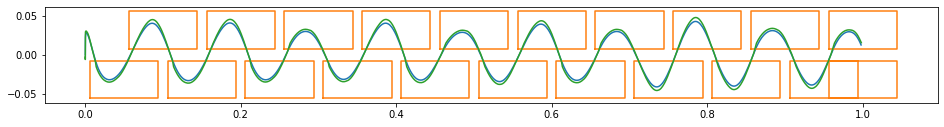

In [11]:
fig = plt.figure(figsize=(16, 2))
ax = fig.subplots(1, 1)
ax.set_aspect('equal')
x, y = zip(*w.com_points)
ax.plot(x, y)
sole = None
for fs in w.footsteps:
    s = np.array([[-0.044, -.024], [0.044, -.024], [0.044, .024], [-0.044, .024], [-0.044, -.024]]) + fs
    if sole is None:
        sole = s
    else:
        sole = np.vstack([sole, np.array([np.nan, np.nan]), s])
xs, ys = zip(*sole)
ax.plot(xs, ys)
x, y = zip(*w.zmp_points)
ax.plot(x, y)
